In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba

L'equazione delle onde musicali è della forma
$$
\frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2} \frac{\partial^2 y}{\partial t^2} - \gamma \frac{\partial y}{\partial t} - l^2 \frac{\partial^4 y}{\partial x^4} = 0
$$
con le seguenti condizioni al contorno
$$
\begin{align*}
&y(0, t) = y(L, t) = 0 \\
&y(x, 0) = f(x)
\end{align*}
$$
dove $L$ è la lunghezza della corda considerata. *Intuizione fisica*: la corda è fissata agli estremi (si ripensi al bridge di una chitarra) e supponiamo che al tempo $t=0^+$ la nostra corda si trovi, dopo una *plettrata*, in una forma modellizzata dalla funzione $f(x)$.
Naturalmente:
* $c$ è la velocità dell'onda (mi pesava il culo scrivere un'altra lettera visto che l'equazione delle onde ormai è il mio mantra di Fisica 2 quindi scriverla con un'altra lettera sarebbe una bestemmia);
* $\gamma$ è il coefficiente di *damping* (perdita di energia nell'oscillazione per dissipazione);
* *l* è la lunghezza *caratteristica* (il coefficiente di rigidezza), ovvero la forza di richiamo dovuta alla deformazione che il corpo subisce.

Ora possiamo discretizzare la nostra equazione differenziale approssimando le derivate con le differenze: discretizzando il nostro spazio in cui si muove la nostra corda e immaginandolo come un grande reticolo di celle che variano nel tempo, indichiamo la  $y_j^i$ l'ampiezza dell'elemento di corda che si trova all'ascissa $j$-esima all'instante di tempo $i$-esimo (discretizziamo spazio e tempo). Pertanto
$$
\frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2} \frac{\partial^2 y}{\partial t^2} - \gamma \frac{\partial y}{\partial t} - l^2 \frac{\partial^4 y}{\partial x^4} \approx \frac{y^{m}_{j+1} - 2 y_j^m + y^m_{j-1}}{\Delta x^2} - \frac{1}{c^2} \frac{y^{m+1}_j - 2y^{m}_{j} + y^{m}_{j-1}}{\Delta t^2}  \gamma \frac{y^{m+1}_j - y^m_{j}}{\Delta t} - l^2 \frac{y^m_{j-2} - 4y^m_{j-1} + 4y^m_j - 4 y^m_{j+1} + y^m_{j+2}}{\Delta x^4} = 0
$$
da cui, risolvendo per $y^{m+1}_{j}$, otteniamo che
$$y_j^{m+1} = \left[\frac{1}{c^2 \Delta t^2} + \frac{\gamma}{2 \Delta t} \right]^{-1} \left[\frac{1}{\Delta x^2} \left( y_{j+1}^{m} -2y_j^m + y_{j-1}^{m} \right) -\frac{1}{c^2 \Delta t^2} \left( y_j^{m-1} - 2y_j^m \right) + \frac{\gamma}{2 \Delta t}y_j^{m-1} -\frac{l^2}{\Delta x^4} \left( y_{j-2}^m -4y_{j-1}^m +6y_{j}^m -4y_{j+1}^m +y_{j+2}^m \right) \right] $$

Studiando l'operatore differenza che abbiamo qua introdotto per approssimare l'equazione differenziale otteniamo che la soluzione associata (risparmio i calcoli da me svolti perché lungo e tedioso) è stabile se $\frac{c\Delta t}{\Delta x} < 1$. Dunque come condizione iniziale utilizziamo naturalmente $c = 308 \frac{m}{s}$ (peffo' stiamo cercando di simulare onde musicali), $L = 0.5 m$, $\Delta x = 0.5 mm$ e $\Delta t = 3 \times 10^{-6} s$. Impostiamo che $N_t$ (l'altezza del nostro rettangolo multidimensionale che rappresenta il tempo) pari a $3000000$. Gli altri parametri facciamo $l = 2.0 \times 10^{-6}$ e $\gamma = 2.6 \times 10^{-5} \frac{s}{m}$. Tempo di andare al codice!

In [697]:
Nx = 200
Nt = 500000
L =0.7
dx = L/(Nx-1)
f = 392
c = 2*L*f
dt = 5e-6
l=2e-5
gamma=6e-5

Ora andiamo a imporre le condizioni iniziali della stringa: le genereremo a caso concatenando due linspace

In [699]:
ya = np.linspace(0, 0.5, 125)
yb = np.linspace(0.5, 0, 75)
y0 = np.concatenate([ya, yb])

Creiamo una matrice di dimensioni $Nt \times Nx$ 

In [701]:
sol = np.zeros((Nt, Nx))
sol[0] = y0
sol[1] = y0

*Osservazione*: potrebbe non risultare chiarissimo perché io decido di settare le prime due righe == y0. La ragione deriva dal fatto che se al passo $m=2$ necessito di accedere alla cella con $t=m-1$ e $t=m-2$: in questa maniera queste sono perfettamente definite.

Creiamo adesso il wrapper di numba per velocizzare la funzione

In [705]:
@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)", nopython=True, nogil=True)
def compute_sol(d, times, length, dt, dx, l, gamma):
    for t in range(1, times-1):
        for i in range(2, length-2):
            outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
    return d

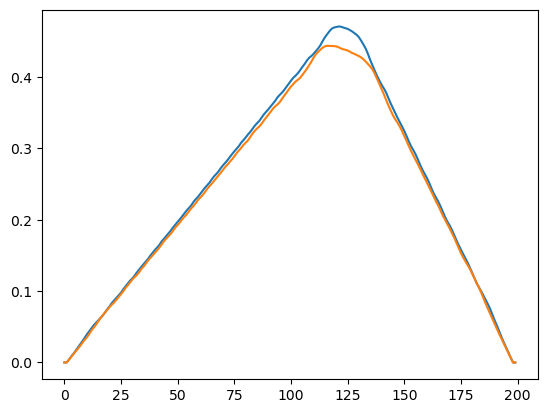

In [707]:
sol = compute_sol(sol, Nt, Nx, dt, dx, l, gamma)
plt.plot(sol[500])
plt.plot(sol[1000])

In questo caso se volessimo creare un'animazione con tutti questi frame abbiamo che $\frac{1}{dt}$ è il numero di fps al secondo, dunque per velocizzare la nostra animazione potremmo pensare di prendere ogni 10 frame circa. Dunque prendiamo $sol[::10, :]$ come slice

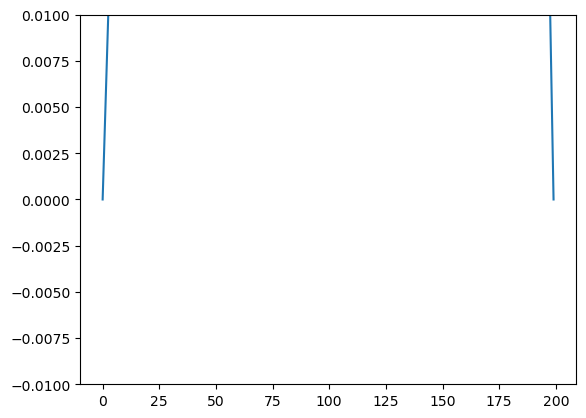

In [709]:
def animate(i):
    ax.clear()
    ax.plot(sol[i*10])
    ax.set_ylim(-0.01, 0.01)
    
fig, ax = plt.subplots(1,1)
ax.set_ylim(-0.01, 0.01)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('string.gif',writer='pillow',fps=20)

Per creare un file *.wav* estriamo le armoniche utilizzando il fatto che possiamo calculare il coefficiente $k$ della serie di Fourier utilizzando il fatto che il prodotto scalare sullo spazio $L^2$ è $\langle \cdot, \cdot \rangle: L^2 \times L^2 \to \mathbb{C}$ è dato da $$\int fg dm_n.$$
Dunque risulterà che
$$
c_k = \int \sin{(n\pi \frac{x}{L})} y(x, t) dx
$$

In [710]:
def get_integral_fast(n):
    sin_arr = np.sin(n*np.pi*np.linspace(0,1,200))
    return np.multiply(sol, sin_arr).sum(axis=1)
hms = [get_integral_fast(n) for n in range(10)]
all_harmonics=True
if all_harmonics:
    tot = sol.sum(axis=1)[::10] # all harmonics
else:
    tot = sum(hms)[::10] # only first 10 harmonics
tot = tot.astype(np.float32)
from scipy.io import wavfile
from IPython.display import Audio
wavfile.write('g.wav',20000,tot)
Audio('g.wav')

In [717]:
c = wavfile.read('c.wav')[1]
e = wavfile.read('e.wav')[1]
g = wavfile.read('g.wav')[1]
wavfile.write('c_maj4.wav', 20000, 2*c+2*e+2*g)
Audio('c_maj4.wav')

## Fast Harmonic (not working)

Implementiamo numba per velocizzare il trovare i coefficienti di Fourier. In quanto stiamo utilizzando delle funzioni di numpy dobbiamo utilizzare il loop-jitting

In [172]:
@numba.jit(nopython=True)
def jget_integral_fast(sol, n):
    sin_arr = np.sin(n * np.pi * np.linspace(0, 1, 101))
    result = np.zeros(sol.shape[0])
    for i in range(sol.shape[0]):  # Ciclo sulle righe
        for j in range(sol.shape[1]):  # Ciclo sulle colonne
            result[i] += sol[i, j] * sin_arr[j]
    return result

# Funzione per sommare i termini armonici
@numba.jit(nopython=True, nogil=True, parallel=True)
def jsum_harmonic(sol, truncate):
    hms = np.zeros(sol.shape[0])  # Array preallocato per i risultati
    for n in numba.prange(truncate):  # Parallelismo su Numba
        term = jget_integral_fast(sol, n)
        for i in range(hms.shape[0]):  # Somma manuale
            hms[i] += term[i]
    return hms[::10]
tot = jsum_harmonic(sol, 10)
tot = tot.astype(np.float32)
from scipy.io import wavfile
from IPython.display import Audio
wavfile.write('sound.wav',20000,tot)
Audio('sound.wav')

Ora, generando varie note a differente frequenza